In [1]:
import os
import math
import random
import seaborn
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping
from collections import namedtuple
from matplotlib.ticker import FormatStrFormatter

In [2]:
df = pd.read_excel("M3C.xls", usecols="A:Z")

df_micro = df.iloc[0:146,]
df_micro = df_micro.iloc[:,6:27]

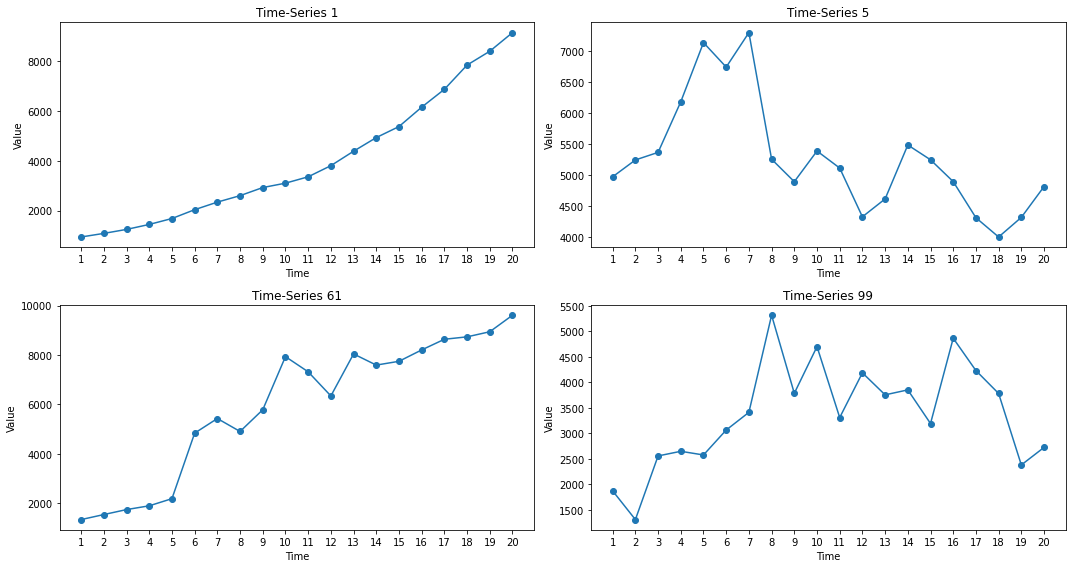

In [238]:
num_rows = 2
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))
axes = axes.flatten()
plots = [0, 4, 60, 98]
for i, ax in enumerate(axes):
    if i < len(df_micro):
        ax.plot(df_micro.iloc[plots[i]], marker="o")
        ax.set_title(f"Time-Series {plots[i]+1}")
        ax.set_xlabel("Time")
        ax.set_ylabel("Value")
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax.set_xticks(range(1, 21))
    else:
        ax.axis("off")

plt.tight_layout()
plt.xticks(list(range(1, 21)))
plt.show()

In [3]:
df_train = df_micro.iloc[:,:-6]
df_test = df_micro.iloc[:, -6:]
df_train_original = df_train.to_numpy().reshape(-1, 14)

In [4]:
# Smoothing
#df_train_unsmoothed = df_train.to_numpy().reshape(-1,14)
def exponential_smoothing(data, alpha=0.8):
    return data.ewm(alpha=alpha, adjust=False).mean()

df_train = exponential_smoothing(df_train)

In [5]:
# Standardising
scaler = StandardScaler()
df_train = scaler.fit_transform(df_train.to_numpy().reshape(-1,1))
df_train = pd.DataFrame(df_train)
MEAN = scaler.mean_
STD = scaler.scale_

0       940.660000
1      1780.972000
2      1525.450400
3       900.722080
4      4161.888416
          ...     
141    4457.508277
142    2064.301655
143    1371.260331
144    1161.700066
145    1003.100013
Name: 1, Length: 146, dtype: float64

In [6]:
df_train = df_train.to_numpy().reshape(-1,14)
df_test = df_test.to_numpy().reshape(-1,6)

<ipython-input-362-05e79d0f15ec>:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data, shade=True, color='blue')


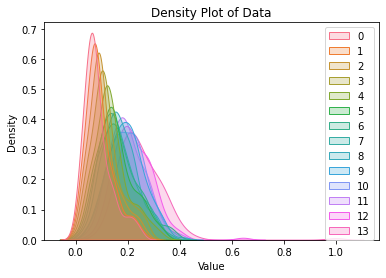

In [362]:
import seaborn as sns

data = scaled_data

# Plotting the density plot
sns.kdeplot(data, shade=True, color='blue')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Density Plot of Data')
plt.show()

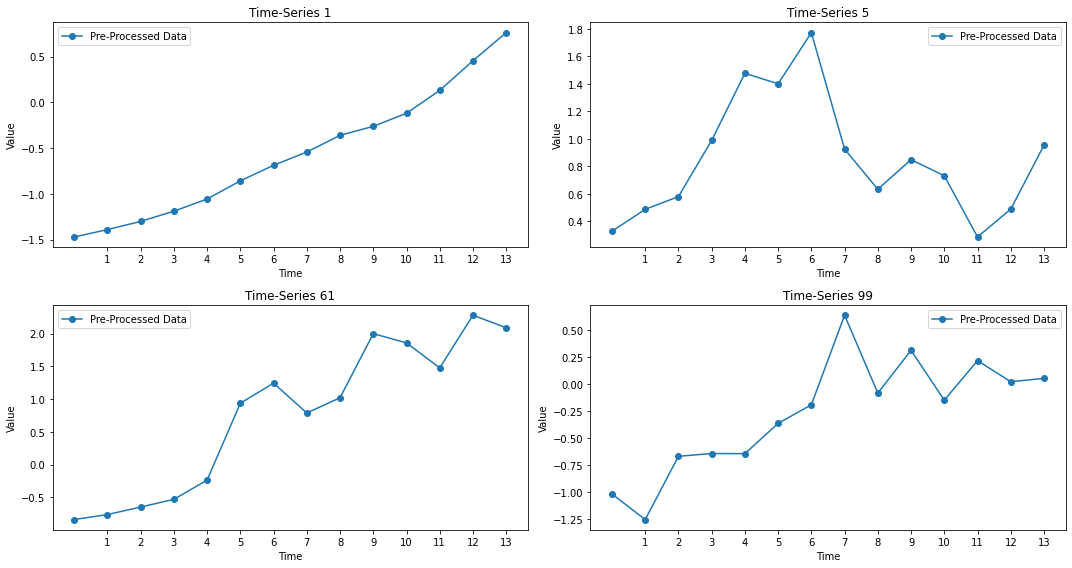

In [429]:
df_train_unsmoothed = df_train
num_rows = 2
num_cols = 2

smoothed_graphs = [0, 4, 60, 98]
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))
axes = axes.flatten()
counter = 0
for i, ax in enumerate(axes):
    if i < len(df_micro):
        ax.plot(df_train[smoothed_graphs[counter]], label="Pre-Processed Data", marker="o")
        ax.set_title(f"Time-Series {smoothed_graphs[counter] + 1}")
        ax.set_xlabel("Time")
        ax.set_ylabel("Value")
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax.set_xticks(range(1, 14))
        ax.legend()
    else:
        ax.axis("off")
    counter = counter + 1

plt.tight_layout()
plt.xticks(list(range(1, 14)))
plt.show()

In [7]:
def get_labelled_window(x, horizon=1):
  return x[:, :-horizon], x[:, -horizon]

def make_windows(x, window_size=4, horizon=1):
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of window size
  windowed_array = x[window_indexes]
  windows, labels = get_labelled_window(windowed_array, horizon=horizon)
  return windows.reshape(-1,4), labels.reshape(-1,1)

In [8]:
train_x = []
train_y = []
test_x = []
test_y = []

for i in range(len(df_train)):
    windows_train, labels_train = make_windows(df_train[i], window_size=4, horizon=1)
    windows_test, labels_test = make_windows(df_test[i], window_size=4, horizon=1)
    train_x = np.concatenate((np.array(train_x).reshape(-1,4), windows_train.reshape(-1,4)))
    train_y = np.concatenate((np.array(train_y).reshape(-1,1), labels_train.reshape(-1,1)))
    test_x = np.concatenate((np.array(test_x).reshape(-1,4), windows_test.reshape(-1,4)))
    test_y = np.concatenate((np.array(test_y).reshape(-1,1), labels_test.reshape(-1,1)))

In [9]:
# SMAPE
def evaluate_smape(y_true, y_pred):
    numerator = tf.abs(y_pred - y_true)
    denominator = (tf.abs(y_pred) + tf.abs(y_true))/2
    smape = tf.reduce_mean(numerator / denominator) * 100
    return smape

def smape_loss(y_true, y_pred):
    numerator = tf.abs(y_pred - y_true)
    denominator = ((tf.abs(y_pred) + tf.abs(y_true))/2) + 0.1
    smape = tf.reduce_mean(numerator / denominator)
    return smape

def metric_mdape(y_true, y_pred):
    return tfp.stats.percentile((tf.abs(tf.math.subtract(y_true, y_pred)/ y_true)), 50.0, interpolation='midpoint')
      
def evaluate_mdape(y_true, y_pred):
    return np.median((np.abs(np.subtract(y_true, y_pred)/ y_true))) * 100

def evaluate_pred(y_true, y_pred):
    # Symmetric mean absolute percentage error
    smape = evaluate_smape(y_true, y_pred)
    # Median symmetric absolute percentage error
    mdape = evaluate_mdape(y_true, y_pred)
    return smape, mdape

In [10]:
# Destandardise
def de_standardise(value):
    return value * STD + MEAN

def standardise(value):
    return (value - MEAN) / STD

In [11]:
# Hyperparameters
Combination = namedtuple("Combination", "learning_rate batch_size regularization hidden_layers hidden_neurons")

learning_rates = np.array([0.001, 0.01, 0.1])
batch_sizes = np.array([16, 32, 64, 128])
regularizations = np.array([0.001, 0.01, 0.001])
hidden_layers = np.array([2, 3, 4, 5, 6, 8]) # 2, 3, 4, 6, 8
hidden_neurons = np.array([2, 3, 4, 5])

combinations = list(itertools.starmap(Combination, itertools.product(learning_rates, batch_sizes, regularizations, hidden_layers, hidden_neurons)))

In [453]:
# Time-series expanding window validation
#with tf.device('/cpu:0'):
    
tf.random.set_seed(42)
eval_scores = []
tscv = TimeSeriesSplit(n_splits=5)
def cross_validation(combination, train_x=train_x, train_y=train_y, tscv=tscv):
    smape_scores = []
    mdape_scores = []

    # Cross-Validation
    for train_index, test_index in tscv.split(train_x):
        train_x_cv, val_x_cv = train_x[train_index], train_x[test_index]
        train_y_cv, val_y_cv = train_y[train_index], train_y[test_index]
        # Create model with selected hyperparameters
        model_cv = tf.keras.Sequential(name="model")

        for i in range(combination.hidden_layers):
            model_cv.add(tf.keras.layers.Dense(combination.hidden_neurons, 
                                            activation="relu", 
                                            kernel_initializer=tf.initializers.HeNormal(), 
                                            kernel_regularizer=tf.keras.regularizers.l2(combination.regularization)))
        model_cv.add(tf.keras.layers.Dense(1, activation="linear", 
                                        kernel_initializer=tf.initializers.HeNormal(), 
                                        kernel_regularizer=tf.keras.regularizers.l2(combination.regularization)))


        model_cv.compile(loss=smape_loss,
                        optimizer=tf.keras.optimizers.Adam(learning_rate=combination.learning_rate),
                        metrics=[metric_mdape, "mae", "mse"]) # Backpropagation
        
        model_cv.fit(train_x_cv, train_y_cv, epochs=50, batch_size=combination.batch_size, verbose=0)

        predictions = model_cv.predict(val_x_cv)

        smape_score, mdape_score = evaluate_pred(de_standardise(val_y_cv), de_standardise(predictions))
        
        smape_scores.append(smape_score)
        mdape_scores.append(mdape_score)
        
    mean_smape = np.mean(smape_scores)
    mean_mdape = np.mean(mdape_scores)
    hyperparameters = {
        'learning_rate': combination.learning_rate,
        'batch_size': combination.batch_size,
        'regularization': combination.regularization,
        'hidden_neurons': combination.hidden_neurons,
        'hidden_layers': combination.hidden_layers
    }
    print(f"Current mean SMAPE: {mean_smape}, Current hyperparameters: {hyperparameters}")
    return mean_smape, mean_mdape, hyperparameters

random_combinations = random.sample(combinations, 20)
results = map(cross_validation, random_combinations)

optimal_smape = float('inf')
optimal_mdape = float('inf')
optimal_hyperparameters = {}
for result in results:
    smape, mdape, hyperparameters = result
    if smape < optimal_smape:
        optimal_smape = smape
        optimal_mdape = mdape
        optimal_hyperparameters = hyperparameters
print("Best Hyperparameters:", optimal_hyperparameters)
print("Best SMAPE Score:", optimal_smape)
print("Best MDAPE Score:", optimal_mdape)

8/8 [==============================] - 0s 1ms/step
Current mean SMAPE: 14.76272261817193, Current hyperparameters: {'learning_rate': 0.001, 'batch_size': 64, 'regularization': 0.001, 'hidden_neurons': 5, 'hidden_layers': 2}
8/8 [==============================] - 0s 1ms/step
Current mean SMAPE: 24.20290435912621, Current hyperparameters: {'learning_rate': 0.001, 'batch_size': 16, 'regularization': 0.001, 'hidden_neurons': 3, 'hidden_layers': 5}
8/8 [==============================] - 0s 926us/step
Current mean SMAPE: 19.708602833890108, Current hyperparameters: {'learning_rate': 0.1, 'batch_size': 16, 'regularization': 0.001, 'hidden_neurons': 3, 'hidden_layers': 2}
8/8 [==============================] - 0s 1ms/step
Current mean SMAPE: 22.755127569156418, Current hyperparameters: {'learning_rate': 0.01, 'batch_size': 16, 'regularization': 0.001, 'hidden_neurons': 4, 'hidden_layers': 8}
8/8 [==============================] - 0s 944us/step
Current mean SMAPE: 34.32891399336332, Current hyp

In [454]:
print(f"Regularization: {optimal_hyperparameters['regularization']}")
print(f"Learning Rate: {optimal_hyperparameters['learning_rate']}")
print(f"Batch Size: {optimal_hyperparameters['batch_size']}")
print(f"Hidden Layers: {optimal_hyperparameters['hidden_layers']}")
print(f"Hidden Neurons: {optimal_hyperparameters['hidden_neurons']}")

model = tf.keras.Sequential([
    #tf.keras.layers.Flatten(input_shape=(4, 1)),
], name="model")

for i in range(optimal_hyperparameters["hidden_layers"]):
    model.add(tf.keras.layers.Dense(optimal_hyperparameters["hidden_neurons"], 
                                    activation="relu", 
                                    kernel_initializer=tf.initializers.HeNormal(), 
                                    kernel_regularizer=tf.keras.regularizers.l2(optimal_hyperparameters["regularization"])))
model.add(tf.keras.layers.Dense(1, activation="linear", 
                                kernel_initializer=tf.initializers.HeNormal(), 
                                kernel_regularizer=tf.keras.regularizers.l2(optimal_hyperparameters["regularization"])))

print()
model.compile(loss=smape_loss,
                optimizer=tf.keras.optimizers.Adam(learning_rate=optimal_hyperparameters["learning_rate"]), 
                metrics=[metric_mdape, "mae", "mse"]) # Backpropagation

early_stopping = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=50)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model_5.hdf5', monitor='loss', mode='min', verbose=1, save_best_only=True)
# Train the model on the full training dataset
model.fit(train_x, train_y, epochs=500, batch_size=optimal_hyperparameters["batch_size"], verbose=1, callbacks=[early_stopping, model_checkpoint])

Regularization: 0.001
Learning Rate: 0.01
Batch Size: 64
Hidden Layers: 4
Hidden Neurons: 3

Epoch 1/500
 1/23 [>.............................] - ETA: 25s - loss: 1.4907 - metric_mdape: 1.5062 - mae: 1.2380 - mse: 2.7473
Epoch 1: loss improved from inf to 1.29758, saving model to best_model_5.hdf5
23/23 [==============================] - 1s 4ms/step - loss: 1.2976 - metric_mdape: 1.1685 - mae: 0.9056 - mse: 1.5713
Epoch 2/500
 1/23 [>.............................] - ETA: 0s - loss: 1.2635 - metric_mdape: 1.2159 - mae: 0.8964 - mse: 1.2739
Epoch 2: loss improved from 1.29758 to 1.21401, saving model to best_model_5.hdf5
23/23 [==============================] - 0s 3ms/step - loss: 1.2140 - metric_mdape: 1.2212 - mae: 0.8429 - mse: 1.2393
Epoch 3/500
 1/23 [>.............................] - ETA: 0s - loss: 1.1497 - metric_mdape: 1.1020 - mae: 0.8612 - mse: 1.3260
Epoch 3: loss improved from 1.21401 to 1.20108, saving model to best_model_5.hdf5
23/23 [==============================] - 0s 3

In [405]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4123 (Dense)          (None, 4)                 20        
                                                                 
 dense_4124 (Dense)          (None, 4)                 20        
                                                                 
 dense_4125 (Dense)          (None, 4)                 20        
                                                                 
 dense_4126 (Dense)          (None, 4)                 20        
                                                                 
 dense_4127 (Dense)          (None, 1)                 5         
                                                                 
Total params: 85
Trainable params: 85
Non-trainable params: 0
_________________________________________________________________


In [12]:
def autoregression(model, x, horizon=6):
    standardised_x = standardise(x)
    for i in range(horizon):
        forecast = model.predict(np.array([standardised_x[i:i+4]]))
        pred = np.array([tf.squeeze(forecast).numpy()])
        standardised_x = np.concatenate((standardised_x, pred))
    return standardised_x[-horizon:]

In [13]:
predictions = []
def evaluate_model_on_test(model, df_train=df_train, df_test=df_test, horizon=1):
    smape_scores = []
    mdape_scores = []
    
    for i in range(len(df_train)):
        window = de_standardise(df_train[i][10:14])
        labels = df_test[i][0:horizon]
        test_preds = autoregression(model, window, horizon)
        #print(f"Destandardised test pred: {de_standardise(test_preds)}")
        
        #print(f"Full Labels: {df_test[i]}")
        #print(f"Window: {window}")
        predictions.append(de_standardise(test_preds))
        print(f"Labels: {labels}, Window: {window}")
        print(f"Label: {labels}, Pred: {de_standardise(test_preds)}")
        smape_score, mdape_score = evaluate_pred(labels, de_standardise(test_preds))
        smape_scores.append(smape_score)
        mdape_scores.append(mdape_score)
        print(f"Current mean SMAPE: {smape_score}, Current mean MDAPE: {mdape_score}")

    mean_smape_score = np.mean(smape_scores)
    mean_mdape_score = np.mean(mdape_scores)
    return mean_smape_score, mean_mdape_score


In [176]:
de_standardise(df_train[1])

array([1255.777, 1451.322, 1652.686, 1909.204, 2294.843, 2994.691,
       3436.602, 3506.101, 3707.609, 3789.712, 3967.509, 3762.201,
       4281.956, 4724.893])

In [14]:
loaded_model = tf.keras.models.load_model("best_model_4.hdf5", custom_objects={"smape_loss": smape_loss, "metric_mdape": metric_mdape})
test1, test2 = evaluate_model_on_test(loaded_model, horizon=6)

1/1 [==============================] - 0s 19ms/step
Labels: [5379.75 6158.68 6876.58 7851.91 8407.84 9156.01], Window: [3360.27 3807.63 4387.88 4936.99]
Label: [5379.75 6158.68 6876.58 7851.91 8407.84 9156.01], Pred: [5117.21777731 5234.3098743  5375.05880511 5532.93801736 5682.39086553
 5817.31160382]
Current mean SMAPE: 27.27867707429826, Current mean MDAPE: 25.68457428117858
1/1 [==============================] - 0s 23ms/step
Labels: [4793.2 5602.  5065.  5056.  5067.2 5209.6], Window: [4979.574 3686.486 4105.416 4371.398]
Label: [4793.2 5602.  5065.  5056.  5067.2 5209.6], Pred: [4654.18429596 4854.32856272 5035.20142274 5208.68501291 5374.89849784
 5530.13647727]
Current mean SMAPE: 5.445232351566619, Current mean MDAPE: 4.546117550579633
1/1 [==============================] - 0s 19ms/step
Labels: [3070.2 3601.6 3407.4 3500.6 3437.8 3007. ], Window: [4471.5948 3055.2172 3426.2032 3694.4396]
Label: [3070.2 3601.6 3407.4 3500.6 3437.8 3007. ], Pred: [4036.09851023 4289.43409365 4510

In [15]:
test1

24.18394600064442

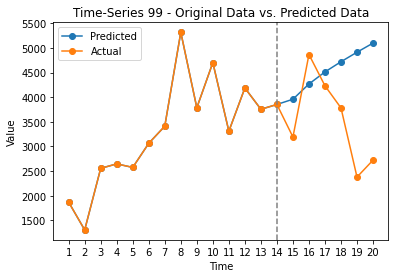

In [20]:
def plot_pred(index):
    testplt = np.append(df_micro.iloc[index][:14], predictions[index])
    plt.plot(list(range(1, 21)), testplt, marker='o', label='Predicted')
    plt.plot(list(range(1, 21)), df_micro.iloc[index].to_numpy(), marker='o', label="Actual")
    plt.axvline(x = 14, color = 'gray', linestyle='--')
    plt.title(f"Time-Series {index+1} - Original Data vs. Predicted Data")
    plt.xticks(list(range(1, 21)))
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.show()
plot_pred(98)